### Notebook versions History
**Version 1:** <br>
Base version <br>
accuracy = 82.85% <br><br>
**Version 2:** <br>
Tried Custom weights and bias. O[](http://)nly weights perform well<br>
Number of epochs decreased because model was converging fast.<br>

# Domain Knowledge

![Pneumonia](https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg)
### Overview
Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia. <br> <br>
Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.
### Causes
Many germs can cause pneumonia. The most common are bacteria and viruses in the air we breathe. Your body usually prevents these germs from infecting your lungs. But sometimes these germs can overpower your immune system, even if your health is generally good. <br> <br>
Pneumonia is classified according to the types of germs that cause it and where you got the infection.
* Community-acquired pneumonia
* Hospital-acquired pneumonia
* Health care-acquired pneumonia
* Aspiration pneumonia <br>
[Read More](https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204)

# Initializing Environment

## EfficientNet Model 
I will use EfficientNet (Rethinking Model) Model. EfficientNet propose a novel model scaling method that uses a simple yet highly effective compound coefficient to scale up CNNs in a more structured manner. Unlike conventional approaches that arbitrarily scale network dimensions, such as width, depth and resolution, our method uniformly scales each dimension with a fixed set of scaling coefficients.<br><br>
**Compound Model Scaling:**
![loading Error](https://1.bp.blogspot.com/-Cdtb97FtgdA/XO3BHsB7oEI/AAAAAAAAEKE/bmtkonwgs8cmWyI5esVo8wJPnhPLQ5bGQCLcBGAs/s640/image4.png)
<br>
Comparison of different scaling methods. Unlike conventional scaling methods (b)-(d) that arbitrary scale a single dimension of the network, scaling method uniformly scales up all dimensions in a principled way.<br><br>
**EfficientNet Architecture**
![loading Error](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)<br>
If you want to know everything about this model click [here](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html#:~:text=EfficientNet%3A%20Improving%20Accuracy%20and%20Efficiency%20through%20AutoML%20and%20Model%20Scaling,-Wednesday%2C%20May%2029&text=Powered%20by%20this%20novel%20scaling,efficiency%20(smaller%20and%20faster).).

In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#libraries

import numpy as np
import pandas as pd 
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
sns.set()

import re, math, cv2, PIL
import os
os.listdir('../input/chest-xray-pneumonia/chest_xray/')

['val', 'train', '__MACOSX', 'test', 'chest_xray']

In [3]:
#getting paths and files

home_dir = '../input/chest-xray-pneumonia/chest_xray/'
nor_train = os.listdir(home_dir + 'train/NORMAL')
pne_train = os.listdir(home_dir + 'train/PNEUMONIA')
nor_val = os.listdir(home_dir + 'val/NORMAL')
pne_val = os.listdir(home_dir + 'val/PNEUMONIA')

## Visualizing some pictures

Normal pictures


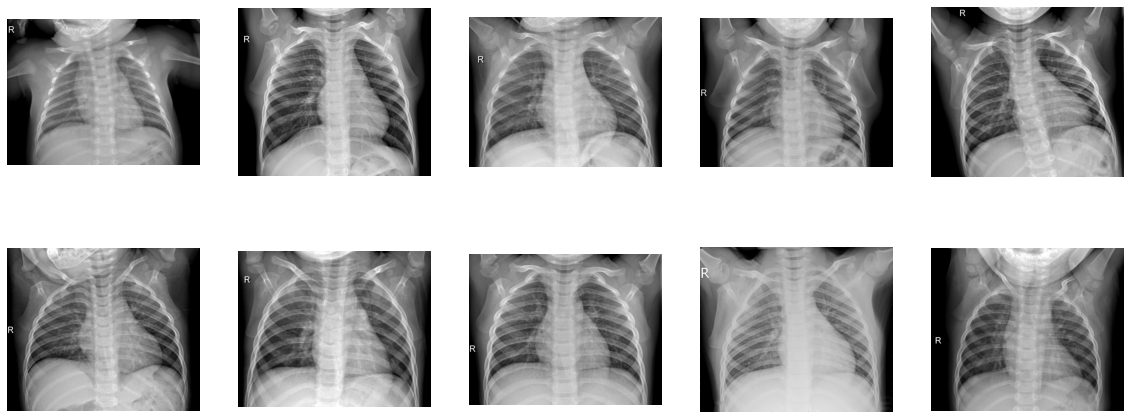

Pneumonia pictures


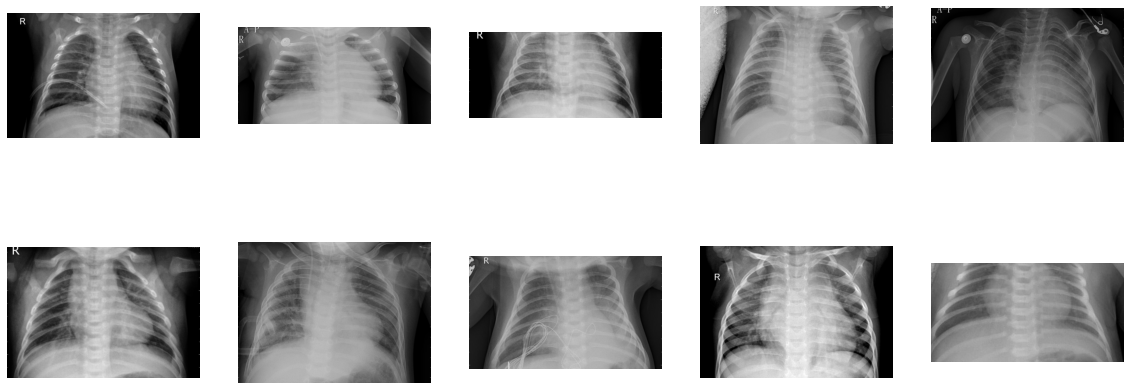

In [4]:
print("Normal pictures")
plt.figure(figsize=[20, 8])
for i in range(10):
    img = cv2.imread(home_dir + 'train/NORMAL/' + nor_train[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

print("Pneumonia pictures")
plt.figure(figsize=[20, 8])
for i in range(10):
    img = cv2.imread(home_dir + 'train/PNEUMONIA/'+ pne_train[i])
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

## Configuration

In [5]:
DEVICE = 'TPU'

#IMAGE SIZES
IMG_SIZE = 256

#batch size and epochs
BATCH_SIZE = 16
EPOCHS = 8

In [6]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"
if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


## Step 1: Preprocess

In [7]:
gcs_path = KaggleDatasets().get_gcs_path('chest-xray-pneumonia')

In [8]:
#method for getting files paths
def get_files_labels(folder):
    normal = os.listdir(home_dir + f'{folder}/NORMAL')
    pneumonia = os.listdir(home_dir + f'{folder}/PNEUMONIA')
    normal_labels = np.int64(np.zeros(len(normal)))
    pneumonia_labels = np.int64(np.ones(len(pneumonia)))
    labels = np.concatenate([normal_labels, pneumonia_labels])
    files_path = [gcs_path + f'/chest_xray/{folder}/NORMAL/{file_name}' for file_name in normal] + [gcs_path + f'/chest_xray/{folder}/PNEUMONIA/{file_name}' for file_name in pneumonia]
    files_path = np.array(files_path)
    return files_path, labels

In [9]:
# get paths
train_files, train_labels = get_files_labels('train')
valid_files, valid_labels = get_files_labels('val')
test_files, test_labels = get_files_labels('test')

Valid files have only 16 pics. I will concatenate with train files and split standard 80, 20.

In [10]:
train_files = np.concatenate([train_files, valid_files])
train_labels = np.concatenate([train_labels, valid_labels])
train_files, valid_files, train_labels, valid_labels = train_test_split(train_files, train_labels, shuffle=True, test_size=0.2)

## Checking imbalancing of Data

In [11]:
# imbalance Valid Data
pd.Series(valid_labels).value_counts()

1    771
0    276
dtype: int64

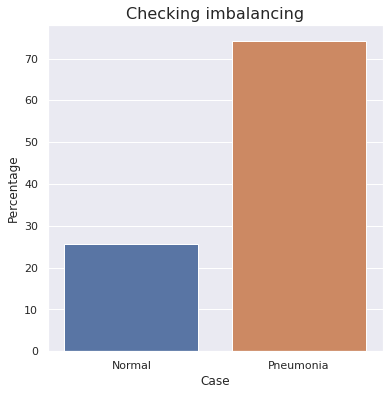

In [12]:
#ploting

imbalance = pd.DataFrame([[len(nor_train), 'Normal'], [len(pne_train), 'Pneumonia']], columns=['Numbers', 'Case'])
imbalance['Percentage'] = round(((imbalance['Numbers'] / sum(imbalance['Numbers'])) * 100),2)
plt.figure(figsize=[6,6])
sns.barplot(x=imbalance['Case'], y=imbalance['Percentage'])
plt.title('Checking imbalancing', fontsize=16)
plt.show()

Our data is imbalance so we will need to fix this.

## Step 2: Data Augmentation

This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96#Data-Augmentation-using-GPU/TPU-for-Maximum-Speed!) and successfully used in Melanoma comp by AgentAuers [here](https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once).

In [13]:
# configuration for augmentation

ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [14]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))

In [15]:
def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [16]:
def prepare_img(img, augment, dim):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [dim, dim])
    img = tf.cast(img, tf.float32) / 255.
    
    if augment:
        img = transform(img, DIM=dim)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_flip_left_right(img)
    
    img = tf.reshape(img, [dim,dim, 3])
    return img

In [17]:
def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                label=None, return_image_names=True):
    if label is not None:
        data = tf.data.Dataset.from_tensor_slices((files, label))
    else:
        data = tf.data.Dataset.from_tensor_slices((files))
    
    data.cache()
    
    if repeat:
        data = data.repeat()
    
    if shuffle:
        data = data.shuffle(1024*3)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        data = data.with_options(opt)
    
    if label is not None:
        data = data.map(lambda img, target: (prepare_img(img, augment, IMG_SIZE), target), num_parallel_calls=AUTO)
    else:
        data = data.map(lambda img: (prepare_img(img, augment, IMG_SIZE)), num_parallel_calls=AUTO)
    
    data = data.batch(BATCH_SIZE * REPLICAS)
    data = data.prefetch(AUTO)
    return data

In [18]:
#get images

train_dataset = get_dataset(train_files, label=train_labels, augment=True, repeat=True, shuffle=True)
valid_dataset = get_dataset(valid_files, label=valid_labels)
test_dataset = get_dataset(test_files, label=test_labels)

## Step 3: Build Model

In [19]:
def build_model(dim, output_bias=None):
    
    #data is imbalance. For imbalance data accuracy metrics is a bad choice. So I'll choose other metrics.  The metrics 
    #Which are specifically for imbalance data.
    
    METRICS = [
      tf.metrics.TruePositives(name='tp'),
      tf.metrics.FalsePositives(name='fp'),
      tf.metrics.TrueNegatives(name='tn'),
      tf.metrics.FalseNegatives(name='fn'), 
      tf.metrics.BinaryAccuracy(name='accuracy'),
      tf.metrics.Precision(name='precision'),
      tf.metrics.Recall(name='recall'),
      tf.metrics.AUC(name='auc'),
    ]
    
    if output_bias is not None:
        output_bias = tf.initializers.Constant(output_bias)
    
    input_layer = tf.keras.Input((dim, dim, 3), name='ImgIn')
    
    base_model = efn.EfficientNetB6(input_shape=(dim, dim, 3), weights='imagenet', 
                          include_top=False)
    
    x = base_model(input_layer)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs= input_layer, outputs = x)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy()
    
    model.compile(optimizer=optimizer, loss= loss, metrics= METRICS)
    return model

## Step 4: Train Schedule

In [20]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

In [21]:
# model check point
sv = tf.keras.callbacks.ModelCheckpoint( 'pneumonia_detection_model.h5', monitor= 'val_loss', verbose=0, 
                                            save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')

## Step 5: Correct for imbalance Data
We saw earlier data is imbalance. Pneumonia has more images than normal. we will fix this here.

In [22]:
# Counts data
#labels are in nd_array so first i'll convert them to pandas series than convert them.
#than use value_counts() 1 indicates pneumonia cases and 0 for normal cases.

COUNT_NORMAL = pd.Series(train_labels).value_counts()[0]
COUNT_PNEUMONIA = pd.Series(train_labels).value_counts()[1]
COUNT_TRAIN = len(train_files)

In [23]:
#initializing bias
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.06480714])

In [24]:
#initializing weights

weight_for_0 = (1/COUNT_NORMAL)*(COUNT_TRAIN)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(COUNT_TRAIN)/2.0

class_weight = {0:weight_for_0, 1:weight_for_1}

print(f'Weight for Normal Class: {weight_for_0}')
print(f'Weight for Pneumonia Class: {weight_for_1}')

Weight for Normal Class: 1.950139794967381
Weight for Pneumonia Class: 0.6723971722365039


Weight of Normal class is greater than Pneumonia because Normal have less images. These weights will balance the CNN for training by increasing images weights.

## Step 6: Train Model

In [25]:
with strategy.scope():
    model = build_model(IMG_SIZE)

165527552/165527152 [==============================] - 14s 0us/step


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImgIn (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnet-b6 (Model)      (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2305      
Total params: 40,962,441
Trainable params: 40,738,009
Non-trainable params: 224,432
_________________________________________________________________


In [27]:
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[sv, get_lr_callback(BATCH_SIZE)], 
                    steps_per_epoch=COUNT_TRAIN/BATCH_SIZE//REPLICAS, validation_data=valid_dataset, verbose=1, 
                    class_weight=class_weight)

Epoch 1/8
32/32 [==============================] - 155s 5s/step - auc: 0.6724 - fn: 1320.0000 - tp: 1710.0000 - fp: 333.0000 - precision: 0.8370 - accuracy: 0.5964 - recall: 0.5644 - loss: 0.6689 - tn: 733.0000 - val_auc: 0.7969 - val_fn: 14.0000 - val_tp: 757.0000 - val_fp: 236.0000 - val_precision: 0.7623 - val_accuracy: 0.7612 - val_recall: 0.9818 - val_loss: 0.6065 - val_tn: 40.0000 - lr: 5.0000e-06
Epoch 2/8
32/32 [==============================] - 121s 4s/step - auc: 0.9244 - fn: 752.0000 - tp: 2318.0000 - fp: 75.0000 - precision: 0.9687 - accuracy: 0.7981 - recall: 0.7550 - loss: 0.4831 - tn: 951.0000 - val_auc: 0.9685 - val_fn: 5.0000 - val_tp: 766.0000 - val_fp: 118.0000 - val_precision: 0.8665 - val_accuracy: 0.8825 - val_recall: 0.9935 - val_loss: 0.4385 - val_tn: 158.0000 - lr: 3.6000e-05
Epoch 3/8
32/32 [==============================] - 105s 3s/step - auc: 0.9629 - fn: 414.0000 - tp: 2622.0000 - fp: 47.0000 - precision: 0.9824 - accuracy: 0.8875 - recall: 0.8636 - loss: 0

## Evaluating / Predictions

In [28]:
loss, tp, tn, fp, fn, acc, precision, recall, auc = model.evaluate(test_dataset)

5/5 [==============================] - 21s 4s/step - auc: 0.9653 - fn: 1.0000 - tp: 389.0000 - fp: 118.0000 - precision: 0.7673 - accuracy: 0.8093 - recall: 0.9974 - loss: 0.4914 - tn: 116.0000


In [29]:
print(f'Model accuracy increased from 0.8285 to {round(acc,4)}')

Model accuracy increased from 0.8285 to 0.8093


**Upvote if you like it. <br>
In next version I'll try test time augmentation.**